In [5]:
# добавления пути до модуля spin_nn
import sys
import os

project_path = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_path not in sys.path:
    sys.path.append(project_path)

In [54]:
from spin_nn.model import MSKModel
from spin_nn.utils import load_mnist
from spin_nn.training import train
from spin_nn.visualization import *
from spin_nn.temp_calc import calc_min_b

import pandas as pd
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

np.set_printoptions(precision=15, suppress=False)

In [60]:
model = MSKModel.load_weights("/Users/rknzhl/projects/spin_glass/code/data/20241219_173925_epochs/weights_epoch_50.json")

Weights and structure loaded from /Users/rknzhl/projects/spin_glass/code/data/20241219_173925_epochs/weights_epoch_50.json


In [61]:
model.weights

[array([[ 0.008295333743447,  0.01574327506893 , -0.033333270342364, ...,
         -0.020523158649705, -0.046392119654743,  0.04155467294624 ],
        [-0.055635137088749, -0.002384248258132,  0.017657080495422, ...,
          0.045837686781578,  0.048103447024675,  0.025907709805593],
        [ 0.057287123592584,  0.059390527175891, -0.010549620724035, ...,
         -0.012565010342113, -0.054241506014446,  0.018424448924157],
        ...,
        [-0.040593506815593, -0.015209748221213,  0.038707776588829, ...,
         -0.015779092458647,  0.041742007372037, -0.021414182752344],
        [-0.009107186013665,  0.019670757740423,  0.072850310485137, ...,
          0.035696918162307, -0.048613065827611,  0.069457200045562],
        [-0.004890641940984,  0.024588058568296, -0.022719061428444, ...,
         -0.008960743521489,  0.018706410586207, -0.032537769113459]],
       shape=(784, 256)),
 array([[-0.026882209250643,  0.005434042690722,  0.018382404350819, ...,
         -0.0141591527

In [62]:
def get_iteraction_matrix(weights):
    total_size = sum(w.shape[0] for w in weights) + weights[-1].shape[1]
    interaction_matrix = np.zeros((total_size, total_size))

    offset = 0
    for i, weight in enumerate(weights):
        rows, cols = weight.shape
        interaction_matrix[offset:offset+rows, offset:offset+cols] = weight
        interaction_matrix[offset:offset+cols, offset:offset+rows] = weight.T
        offset += rows
    return interaction_matrix

In [68]:
def build_j_matrix(weights_list):
    layer_sizes = []
    # Предполагается, что weights_list не пуст
    N0 = weights_list[0].shape[0]
    layer_sizes.append(N0)
    for W in weights_list:
        out_size = W.shape[1]
        layer_sizes.append(out_size)
    total_size = sum(layer_sizes)
    J = np.zeros((total_size, total_size))

    offsets = np.cumsum([0] + layer_sizes)

    for k, W in enumerate(weights_list):
        in_start = offsets[k]
        in_end = offsets[k+1]
        out_start = offsets[k+1]
        out_end = offsets[k+2]
        # Заполняем блоки:
        J[in_start:in_end, out_start:out_end] = W
        J[out_start:out_end, in_start:in_end] = W.T
        # Отладочная печать:
        print(f"Вставили блок W^{k+1}: shape={W.shape}, "
              f"J[{in_start}:{in_end}, {out_start}:{out_end}]")

    return J

In [70]:
J = get_iteraction_matrix(model.weights)

print("Min value in J:", np.min(J))
print("Max value in J:", np.max(J))

Вставили блок W^1: shape=(784, 256), J[0:784, 784:1040]
Вставили блок W^2: shape=(256, 10), J[784:1040, 1040:1050]
Min value in J: -0.2390142150233686
Max value in J: 0.16687815626756963


In [71]:
print(J)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [66]:

def build_M_matrix(J, beta):
    N = J.shape[0]
    # Вычисляем a_i = sum_{ell} J_{iell}^2 для каждой строки
    a = np.sum(J**2, axis=1)  # вектор длины N
    # Формируем M
    # M = beta * J - beta^2 * diag(a)
    M = beta * J - np.diag(beta**2 * a)
    return M

def find_min_eigval(J, beta):
    N = J.shape[0]
    M = build_M_matrix(J, beta)
    A = np.eye(N) - M  # I_N - M
    eigvals = np.linalg.eigvalsh(A)  # для симметричной матрицы
    return np.min(eigvals)

Approximate critical beta: 0.9696969696969697


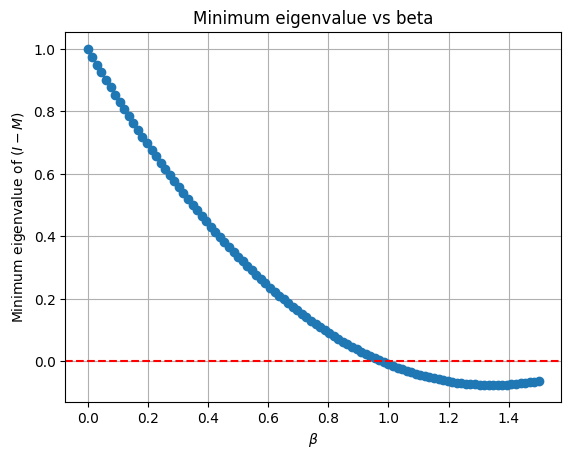

In [72]:
betas = np.linspace(0, 1.5, 100)
min_eigs = []
for b in betas:
    val = find_min_eigval(J, b)
    min_eigs.append(val)

# Ищем бету, при которой min_eig максимально близко к 0
# Аргумент минимального по абсолютному значению собственноого числа
idx_closest = np.argmin(np.abs(min_eigs))
beta_crit = betas[idx_closest]
print("Approximate critical beta:", beta_crit)

# Строим график минимального собственного числа от беты
plt.figure()
plt.plot(betas, min_eigs, marker='o')
plt.axhline(0, color='r', linestyle='--')
plt.xlabel(r'$\beta$')
plt.ylabel('Minimum eigenvalue of $(I - M)$')
plt.title('Minimum eigenvalue vs beta')
plt.grid(True)
plt.show()